In [ ]:
import pandas as pd;
import matplotlib.pyplot as plt;
import pandas.io.sql as sqlio;
import psycopg2 as ps;
import numpy as np;
import seaborn as sns;
from category_encoders import OneHotEncoder;
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

In this project we will work with data from **Open Data Nepal** to predict earthquake damage from Nepal 2015 earthquake. We are working with **Sindhupalchok** district in the first 3 projects and with **Okhaldhunga** in the last project. we will build **machine learning models** using **Logistic Regression** and **Decision Trees Classifiers**. These two algorithms deal with **binary classification** problems, which will be explained a little bit later during the project. Right now let's focus to a new way of extracting a dataset, through an existing database in **postgresql**. We will connect the database with our notebook, execute its sql code and then create a dataframe with data from our existing database. As in our previous projects, this project will have its **wrangle** function, where all the **data wrangling and cleaning** codes will take part.

**Definition: Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc)**.

# Prepare Data

## Import

In [ ]:
def wrangle(dbname, user, password, host, port):
    #Connect to database
    conn2 = ps.connect(dbname = dbname,
                  user = user,
                  password = password,
                  host = host,
                  port = port)

    #Construct query
    sql = """SELECT * FROM public."NepalEarthquakeDamage2015" as Nepal
    where Nepal."district_id" = 36"""

    #Read query into dataframe
    df = pd.read_sql(sql, conn2, index_col="building_id")

    #Identifying high leakage features
    drop_cols = [leakage for leakage in df.columns if "post_eq" in leakage]

    #Drop multicollinearity columns
    drop_cols.append("count_floors_pre_eq")

    #Drop low or high cardinality features
    drop_cols.append("district_id")

    #Convert values into 0s and 1s
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int);
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int);

    drop_cols.append("damage_grade")

    #Dropping columns
    df.drop(columns = drop_cols, inplace = True)

    return df

In [ ]:
df = wrangle("postgres", "postgres", "teknologji", "localhost", "5432");

In [ ]:
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,severe_damage
building_id,,,,,,,,,,,
360204001191,15,345,18,Steep slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Attached-1 side,Rectangular,1
360204001441,40,640,19,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Attached-1 side,Rectangular,1
360204001451,20,350,19,Steep slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,1
360204001461,15,400,19,Steep slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,1
360301001381,2,862,10,Flat,RC,RCC/RB/RBC,RC,Not applicable,Attached-2 side,Rectangular,0


Since we want to predict whether a building is going to suffer severe damage or not, in an earthquake, we want our model to make those predictions, before earthquake happens, so pre-earthquake. We can see we have features in our dataset, that give information about the buildings conditions after earthquake, so post-earthquake. These are high leakage values that need to be removed.
Below ilustrating a photo with the features, needed to be dropped:

**df.info()** will show us this photo (**since we have made changes with dropping these features, we upload a photo with previously saved features**

We want to build a **binary classification model**, having as a target **damage_grade** column, but it contains more than 1 value, Grade1-Grade5. We will transform its value in 0s and 1s. If the damage_grade is more than 4 then it will take 1 as a value, if it's less than 4 then it will take 0 as a value. Values will be stored as 0s and 1s in a new column; **severe_damage** in the wrangle function.

## Explore

Since we will be building a linear model, we need to make sure there is no **multicollinearity** in our dataset. Let's build a heatmap, and see that.

In [ ]:
#corr = df.select_dtypes("number").drop(columns = "severe_damage").corr()
#sns.heatmap(corr)

Floors and height are highly correlated with each other. So we need to remove one of these features. To decide this we need to see the correlation between **severe_damage** with each one of these columns.

corr(severe_damage and count_floors_pre_eq) ~ 0.02
corr(severe_damage and height_ft_pre_eq) ~ -0.03

We will remove the first, count_floors_pre_eq, since it has a smaller correlation value or it's less correlated with **severe_damage** column.

(78074, 11)

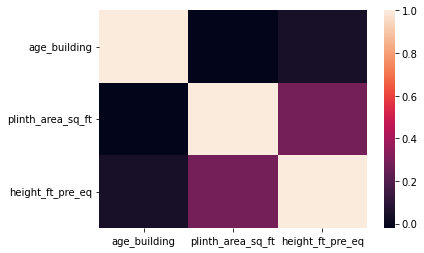

In [ ]:
corr = df.select_dtypes("number").drop(columns = "severe_damage").corr()
sns.heatmap(corr)

df.shape

Before we start building our model, let's see the differences of buildings severely damaged (severe_damage == 1) and those not severely damaged (severe_damage == 0).

We will create a boxplot, showing the distributions of "height_ft_pre_eq" columns for both groups "severe_damage".

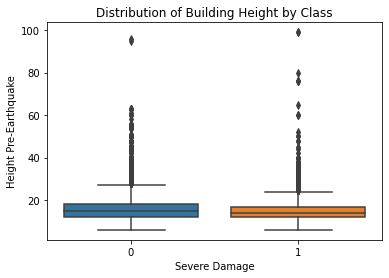

In [ ]:
sns.boxplot(x = "severe_damage", y = "height_ft_pre_eq", data = df)
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-Earthquake")
plt.title("Distribution of Building Height by Class");
plt.show()

From the boxplots above we can see that, most of the plots that didn't suffered severe damage are below 20 feet, but we have an almost identical distribution with buildings severely_damaged. There is not a lot of difference in these distributions from a model building perspective. Now we will compare the relative frequencies of the classes.

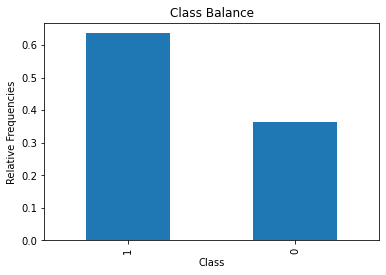

In [ ]:
df["severe_damage"].value_counts(normalize = True).plot(kind = "bar",
                                                       xlabel = "Class",
                                                       ylabel = "Relative Frequencies",
                                                       title = "Class Balance")
plt.show()

Our positive class, class 1 counts for more than 60 % of our observations. One of these classes will be the most representative class so  majority_class (class 1) and the other one minority_class (class 0).

In [ ]:
majority, minority = df["severe_damage"].value_counts(normalize = True)
print("Majority class Frequency", round(majority,2))
print("Minority class Frequency", round(minority,2))

Majority class Frequency 0.64
Minority class Frequency 0.36


Are there foundation types more likely to suffer severe damage?

In [ ]:
foundation_pivot = pd.pivot_table(df, index = "foundation_type",
                                  values = "severe_damage",
                                  aggfunc = np.mean).sort_values(by = "severe_damage")


foundation_pivot

,severe_damage
foundation_type,
RC,0.027134
Bamboo/Timber,0.321429
Cement-Stone/Brick,0.410200
Mud mortar-Stone/Brick,0.684101
Other,0.801020


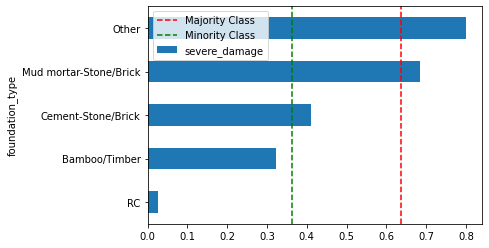

In [ ]:
#Let's plot this pivot table
foundation_pivot.plot(kind = 'barh', legend = None)
plt.axvline(majority, linestyle = '--', color = 'red', label = 'Majority Class')
plt.axvline(minority, linestyle = '--', color = 'green', label = 'Minority Class')
plt.legend()
plt.show()

From the chart above, **Mud mortar - Stone/Brick** and **Other** category is more likely to suffer severe damage.

## Split

In [ ]:
target = "severe_damage"
X = df.drop(columns = "severe_damage")
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (62459, 10)
y_train shape: (62459,)
X_test shape: (15615, 10)
y_test shape: (15615,)


# Build Model

## Baseline

For classification problems, **accuracy_score** is a metric.This metric is equal to the correct observations during classification process.

$$ \frac{\text{number of correct observations}}{\text{number of observations}}.$$

In [ ]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline accuracy is: ",round(acc_baseline,2))

Baseline accuracy is:  0.64


## Iterate

**Logistic Regression** is a sigmoid function. The result will represent the probability of the prediction occurring. Its formula is shown below.

In [ ]:
#Build Model
model = make_pipeline(OneHotEncoder(use_cat_names = True),
                     LogisticRegression(max_iter = 10000))

model.fit(X_train, y_train)

C:\Users\insgesa\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=10000))])

## Evaluate

In [ ]:
#Calculate training and test accuracy score (2 ways to calculate accuracy score)
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train,3))
print("Test Accuracy:", round(acc_test,3))

Training Accuracy: 0.705
Test Accuracy: 0.707


We can see we have beaten the baseline accuracy score, and our generalization process have gone very well with similar result as training one. Now let's communicate the results!

# Communicate

In [ ]:
#predict probability

y_train_probability = model.predict_proba(X_train)
print(y_train_probability[:10])

[[0.34244486 0.65755514]
 [0.59934847 0.40065153]
 [0.33513228 0.66486772]
 [0.30950298 0.69049702]
 [0.17402471 0.82597529]
 [0.30935566 0.69064434]
 [0.24173546 0.75826454]
 [0.30347328 0.69652672]
 [0.30844036 0.69155964]
 [0.2430071  0.7569929 ]]


In that nested list above, we have the probabilities of buildings severely damaged and not severely_damaged. We can take those exact data of probabilities, just to be more exact, instead of just showing them with **predict** method as below.

In [ ]:
#0th index above stays for not severely damaged and 1st index for severely damaged
y_train_probability_1 = model.predict(X_train)
print(y_train_probability_1[:10])

[1 0 1 1 1 1 1 1 1 1]


In [ ]:
#Extracting feature names and importances from our model
features = model.named_steps["onehotencoder"].get_feature_names()
features

['age_building',
 'plinth_area_sq_ft',
 'height_ft_pre_eq',
 'land_surface_condition_Flat',
 'land_surface_condition_Steep slope',
 'land_surface_condition_Moderate slope',
 'foundation_type_Mud mortar-Stone/Brick',
 'foundation_type_RC',
 'foundation_type_Bamboo/Timber',
 'foundation_type_Cement-Stone/Brick',
 'foundation_type_Other',
 'roof_type_Bamboo/Timber-Heavy roof',
 'roof_type_Bamboo/Timber-Light roof',
 'roof_type_RCC/RB/RBC',
 'ground_floor_type_Mud',
 'ground_floor_type_RC',
 'ground_floor_type_Brick/Stone',
 'ground_floor_type_Timber',
 'ground_floor_type_Other',
 'other_floor_type_Not applicable',
 'other_floor_type_TImber/Bamboo-Mud',
 'other_floor_type_Timber-Planck',
 'other_floor_type_RCC/RB/RBC',
 'position_Not attached',
 'position_Attached-1 side',
 'position_Attached-2 side',
 'position_Attached-3 side',
 'plan_configuration_Rectangular',
 'plan_configuration_L-shape',
 'plan_configuration_Square',
 'plan_configuration_Multi-projected',
 'plan_configuration_T-shap

In [ ]:
importances = model.named_steps["logisticregression"].coef_[0]
importances

array([ 8.67324906e-04,  1.93740867e-04,  2.35373267e-03, -3.76113915e-01,
        3.06255287e-01, -2.39606742e-01,  7.06431570e-01, -1.16253566e+00,
       -6.64401037e-01,  1.22741765e-01,  6.88297989e-01,  4.59927472e-01,
        2.86692507e-01, -1.05608535e+00,  1.76681865e-02, -1.00108069e+00,
        1.21114006e-01,  5.92261509e-01, -3.94283772e-02, -1.16845233e-01,
        7.11224699e-02,  4.74357644e-01, -7.38100251e-01, -1.69447815e-01,
       -4.89013798e-02, -4.42108038e-02, -4.69053719e-02,  3.07556307e-01,
       -3.23397695e-01,  4.17170268e-02, -2.40366025e-01, -7.31524449e-03,
       -1.76895070e-02, -6.48633958e-02,  8.29457770e-03, -1.90940747e-03,
       -1.14920067e-02])

In [ ]:
#Logistic regression is an exponential regression so we use np.exp for that
ratios_series = pd.Series(np.exp(importances), index = features).sort_values()
ratios_series

foundation_type_RC                                    0.312692
roof_type_RCC/RB/RBC                                  0.347815
ground_floor_type_RC                                  0.367482
other_floor_type_RCC/RB/RBC                           0.478021
foundation_type_Bamboo/Timber                         0.514582
land_surface_condition_Flat                           0.686524
plan_configuration_L-shape                            0.723686
plan_configuration_Multi-projected                    0.786340
land_surface_condition_Moderate slope                 0.786937
position_Not attached                                 0.844131
other_floor_type_Not applicable                       0.889723
plan_configuration_U-shape                            0.937195
position_Attached-1 side                              0.952275
position_Attached-3 side                              0.954178
position_Attached-2 side                              0.956752
ground_floor_type_Other                               0

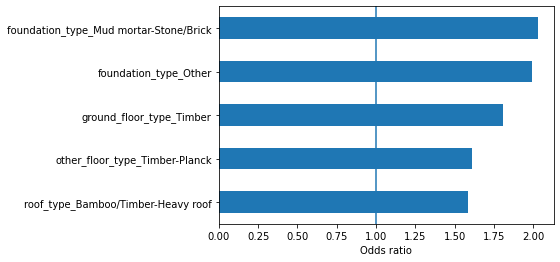

In [ ]:
#Bar chart with 5 largest coefficients
ratios_series.tail().plot(kind = "barh")
plt.xlabel("Odds ratio")
plt.axvline(1)
plt.show()

From the chart above we can see that foundations as **Mud mortar-Stone/Brick** are twice more likely (so 200%) to suffer severe damage from the earthquake.

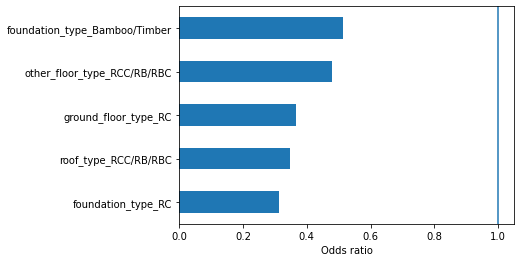

In [ ]:
#Bar chart with 5 smallest coefficients
ratios_series.head().plot(kind = "barh")
plt.xlabel("Odds ratio")
plt.axvline(1)
plt.show()

While in this case, the foundation type **Bamboo/Timber** is 50% less likely to suffer from severe damage from the earthquake.